<a href="https://colab.research.google.com/github/Krankile/ensemble-forcasting/blob/main/LSTM_feature_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import copy
import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DRIVE_PATH = "/content/drive/MyDrive/10 – NTNU/# 9. Semester/Prosjektoppgave_runs"

In [46]:
%%capture
!pip install wandb --upgrade

In [47]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config = dict(
    epochs=150,
    embedding_dim=128,
    hidden_dim=256,
    learning_rate=1e-3,
    dataset="droso-3class-v01",
    architecture="LSTM",
)

In [5]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [6]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim, hidden_dim, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len = seq_len
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.n_features = n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [7]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [8]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    starttime = datetime.now()
    logpath = f"{DRIVE_PATH}-logs-{starttime}"

    with open(logpath, mode="w") as f:
        f.write("Epoch;Train_loss;Val_loss\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    # Test with sMAPE and MASE as well maybe
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    it = tqdm(range(1, n_epochs + 1))

    for epoch in it:
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        with open(logpath, mode="a") as f:
            f.write(f"{epoch};{train_loss};{val_loss}\n")

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            with open(DRIVE_PATH + "model_weights", "wb") as f:
                torch.save(best_model_wts, f)

        it.set_postfix(
            train_loss=train_loss,
            val_loss=val_loss
        )

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [21]:
train_dataset = []

xs = np.linspace(-1, 1, 500)

for i in xs:
    train_dataset.append(np.linspace(i, i, 100))
    train_dataset.append(np.linspace(-i, i, 100))
    train_dataset.append(-i*np.sin(np.linspace(-i*4*np.pi, i*4*np.pi, 100)))

# NBNB
val_dataset = random.sample(train_dataset, k=int(0.1 * len(train_dataset)))

train_tensor = torch.Tensor(train_dataset).reshape((-1, 100, 1))
val_tensor = torch.Tensor(val_dataset).reshape((-1, 100, 1))

_, seq_len, n_features = train_tensor.shape

In [ ]:
model = RecurrentAutoencoder(
    seq_len=seq_len,
    n_features=n_features,
    embedding_dim=config["embedding_dim"],
    hidden_dim=config["hidden_dim"]
)

model = model.to(device)

model, history = train_model(
    model,
    train_tensor,
    val_tensor,
    n_epochs=150,
)
model = model.cpu()

 61%|██████    | 91/150 [2:59:31<1:55:34, 117.54s/it, train_loss=13.2, val_loss=55]

## Check results

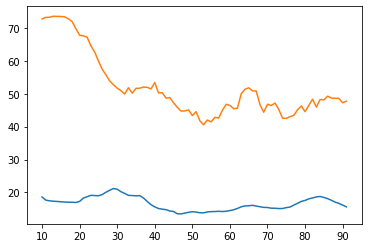

In [19]:
# Plot training data
logspath = "/content/drive/MyDrive/# 9. Semester/Prosjektoppgave_runs-logs-2021-10-20 15:58:18.177512"

logs = pd.read_csv(logspath, sep=";").set_index("Epoch")
logs["tloss_smooth"] = logs["Train_loss"].rolling(10).mean()
logs["vloss_smooth"] = logs["Val_loss"].rolling(10).mean()
plt.plot(logs["tloss_smooth"]);
plt.plot(logs["vloss_smooth"]);

In [43]:
model = RecurrentAutoencoder(seq_len=seq_len, n_features=n_features, embedding_dim=128)
model.load_state_dict(torch.load("/content/drive/MyDrive/# 9. Semester/Prosjektoppgave_runsmodel_weights"))
model = model.eval().cpu()

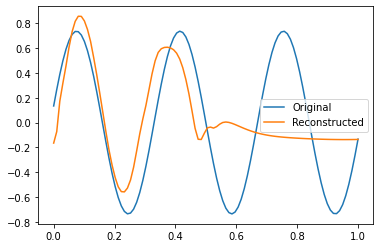

In [45]:
series = 200

plt.plot(np.linspace(0, 1, 100), train_tensor[series], label="Original");
plt.plot(np.linspace(0, 1, 100), model(train_tensor[series]).detach().numpy(), label="Reconstructed")
plt.legend();